Cleaning Data for Analysis 

In [7]:
#import statements
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

In [8]:
#function definitions
def PlotScatter(yhat):
    fig, ax = plt.subplots()
    ax.scatter(yhat, yTest)
    ax.set_xlabel('Predicted Sale Price (in Millions)')
    ax.set_ylabel('Actual Sale Price (in Millions)')
    return ax

Because not all new construction homes were sold, and among those that were sold, not all reported the sale price. Those cases simply list sale price (SLPR) as 0. Because for our analysis these examples are not of interest to us they will be removed. Additionally there are two variables that indicate the sale price of the home: SLPR and FSLPR. FSLPR (Final Sale Price) is only filled in if the SLPR was changed before the final closing date. Because we would like the most accurate information FSLPR and SLPR will be combined into FSLPR filling in the missing information of FSLPR with SLPR.

In [9]:
## Reading and cleaning data
raw_data = pd.read_csv('soc19.csv')
print(raw_data.shape)

## Remove rows where sale price was not reported or house was not sold 
raw_data = raw_data[(raw_data['SLPR'] != 0) | (raw_data['FSLPR'] != 0)]

## If FSLPR is zero, replace this value with SLPR
raw_data.FSLPR[raw_data.FSLPR == 0] = raw_data.SLPR

## Features to remove 
remove_features = ["SLPR", "FCONPR", "SALE", "COMP", "AUTH", "ID", "STRT", "PVALU", "FNSQ_F", "CONPR", "FINC",
               "SLPR_F", "FSLPR_F", "FCONPR_F", "LOTV_F", "SQFS_F", "FSQFS_F", "PVALU_F", "AREA_F", "CONPR_F"]

## Removing Features 
raw_data = raw_data.drop(columns = remove_features)
 
## clean data export
cleaned_data = raw_data 
#cleaned_data.to_csv('cleaned_data.csv', index=False)
print(cleaned_data.shape)

## Creating a data dictionary to specify data types 
feature_types = {"ACS": 'category', "AGER": 'category', "ASSOC": 'category', "BASE": 'category',
                "CAT": 'category', "CLOS": 'category', "CON": 'category', "DECK": 'category',
                "DET": 'category', "DIV": 'category', "FNBS": 'category', "FOYER": 'category',
                "FRAME": 'category', "GAR": 'category', "HEAT": 'category', "HEAT2": 'category',
                "LNDR": 'category', "MFGS": 'category', "PATI": 'category', "PRCH": 'category',
                "SEWER": 'category', "STOR": 'category', "WAL1": 'category', "WALS": 'category',
                "WATER": 'category', "BEDR": 'category', "FPLS": 'category', "FULB": 'category',
                "HAFB": 'category', "WEIGHT": int, "FUEL": 'category', "FUEL2": 'category',
                "FSLPR": np.float64, "SQFS": np.float64, "FSQFS": np.float64, "LOTV": np.float64,
                "FFNSQ": np.float64, "AREA": np.float64}

## Changing data types of features
cleaned_data = cleaned_data.astype(feature_types)

#create train and test set
x = cleaned_data.loc[:, cleaned_data.columns != 'FSLPR']
y = cleaned_data.loc[:, cleaned_data.columns == 'FSLPR']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 1)

## Create 1d arrays of training and test sample weights 
training_weights = xTrain.loc[:, xTrain.columns == 'WEIGHT'].values.flatten()
testing_weights = xTest.loc[:, xTest.columns == 'WEIGHT'].values.flatten()

## Drop sample weights from training and testing data sets so not included in model
xTrain = xTrain.drop(columns = 'WEIGHT')
xTest = xTest.drop(columns = 'WEIGHT')

(24810, 61)
(13257, 41)


General Data Exploration: Stats stuff not necessarily related to machine learning

In [10]:
#summary statistics
cleaned_data['FSLPR'].describe()

count    1.325700e+04
mean     4.061244e+05
std      2.234747e+05
min      1.100000e+05
25%      2.610000e+05
50%      3.500000e+05
75%      4.850000e+05
max      2.395000e+06
Name: FSLPR, dtype: float64

Text(0.5, 1.0, 'Distribution of Final Sale Price')

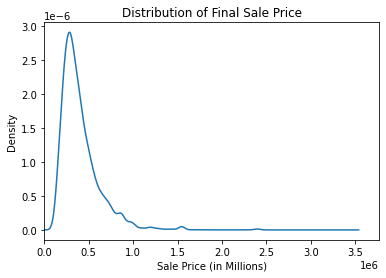

In [11]:
FSLPRdensity = cleaned_data['FSLPR'].plot(kind = 'density')
FSLPRdensity.set_xlabel('Sale Price (in Millions)')
FSLPRdensity.set_xlim(0)
FSLPRdensity.set_title('Distribution of Final Sale Price')

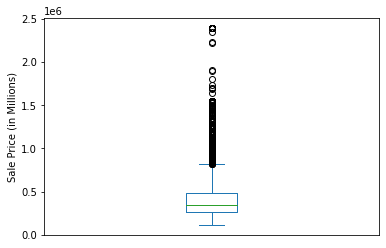

In [12]:
FSLPRbox = cleaned_data['FSLPR'].plot(kind = 'box') #lot of high outliers
FSLPRbox.set_ylabel('Sale Price (in Millions)')
FSLPRbox.xaxis.set_visible(False)

Model Implementation

In [13]:
## Simple linear regression as baseline 
reg = LinearRegression()
reg.fit(xTrain, yTrain,
        sample_weight = training_weights)

LinearRegression()

In [25]:
## Asses linear regression model
yHatReg = reg.predict(xTest)
score_reg = reg.score(xTest, yTest,
                      sample_weight = testing_weights)
print('Coefficient of determination on test set:', np.round(score_reg,2))
print('MSE:', mean_squared_error(yTest, yHatReg, sample_weight= testing_weights))

Coefficient of determination on test set: 0.47
MSE: 22814747723.254948


In [15]:
#Random Forest
rForest = RandomForestRegressor(n_estimators=500)

# hyper-parameter optimization was run with the following grid search layout
# I have commented it out and changed the main regressor to reflect the best parameters to save time

# params = {
#        'n_estimators': [100, 250, 500, 1000],
# }

# gridForest = GridSearchCV(estimator = rForest, param_grid = params, n_jobs = -1)
# gridForest.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)
# print('best parameters:', gridForest.best_params_)

rForest.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)

RandomForestRegressor(n_estimators=500)

In [24]:
#evaluate model in another cell so don't need to refit model every time
yHatForest = rForest.predict(xTest)
scoreForest = rForest.score(xTest, yTest, sample_weight = testing_weights)
print('Coefficient of determination on test set:', np.round(scoreForest,2)) 
print('MSE:', mean_squared_error(yTest, yHatForest, sample_weight = testing_weights))
#PlotScatter(yHatForest)

Coefficient of determination on test set: 0.79
MSE: 9120128473.307388


In [17]:
#train decision tree
tree = DecisionTreeRegressor(criterion = 'friedman_mse',
                            max_depth = 10,
                            min_samples_split = 10,
                            random_state = 1)

# params = {
#        'criterion': ['squared_error', 'friedman_mse'],
#        'splitter': ['best', 'random'],
#        'max_depth': [5, 10, 15, None],
#        'min_samples_split': [2, 5, 10],
#        'max_features': ['auto', 'sqrt', 'log2'],
#        'random_state': [1]

# }

# gridTree = GridSearchCV(estimator = tree, param_grid = params, n_jobs = -1)
# gridTree.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)
# print('best parameters:', gridTree.best_params_)
# print('best score', gridTree.best_score_)

tree.fit(xTrain, yTrain, sample_weight = training_weights)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      min_samples_split=10, random_state=1)

coefficient of determination on test set: 0.69


<AxesSubplot:xlabel='Predicted Sale Price (in Millions)', ylabel='Actual Sale Price (in Millions)'>

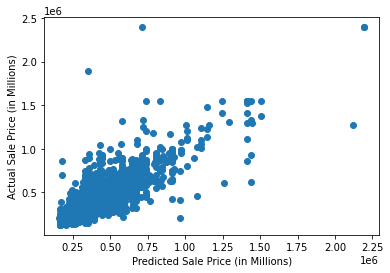

In [18]:
#assess tree
yHatTree = tree.predict(xTest)
scoreTree = tree.score(xTest, yTest, sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(scoreTree,2))
print('MSE:', mean_squared_error(yTest, yHatTree, sample_weight = testing_weights))
#PlotScatter(yHatTree)

Gradient Boosting Model

In [19]:
#Gradient boosting 
GBR = GradientBoostingRegressor(n_estimators = 500, max_depth = 5)

# hyper-parameter optimization was run with the following grid search layout
# I have commented it out and changed the main regressor to reflect the best parameters to save time

# params = {
#        'learning_rate': [0.01, 0.05, 0.1, 0.2], 
#        'n_estimators': [100, 250, 500, 1000],
#        'max_depth': [1, 2, 3, 4, 5, 10]     
# }

# gridGBR = GridSearchCV(estimator = GBR, param_grid = params, n_jobs = -1)
# gridGBR.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)
# print('best parameters:', gridGBR.best_params_)

GBR.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)


GradientBoostingRegressor(max_depth=5, n_estimators=500)

coefficient of determination on test set: 0.78


<AxesSubplot:xlabel='Predicted Sale Price (in Millions)', ylabel='Actual Sale Price (in Millions)'>

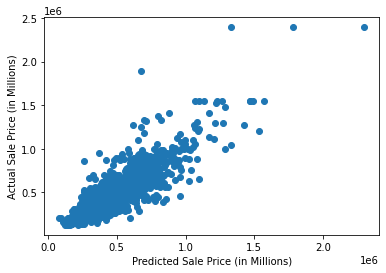

In [20]:
#assess gradient boosting model
yHatGBR = GBR.predict(xTest)
scoreGBR = GBR.score(xTest, yTest, sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(scoreGBR, 2))
print('MSE:', mean_squared_error(yTest, yHatGBR, sample_weight = testing_weights))
#PlotScatter(yHatGBR)

In [21]:
## Train KNN model
KNN_reg = KNeighborsRegressor(n_neighbors = 15,
                             metric='wminkowski',
                            p=2, 
                           metric_params={'w': training_weights})
KNN_reg.fit(xTrain, yTrain)

KNeighborsRegressor(metric='wminkowski',
                    metric_params={'w': array([65, 76, 27, ..., 76, 25, 45])},
                    n_neighbors=15)

In [22]:
## Assesing KNN model 
scoreKNN = KNN_reg.score(xTest, yTest,
                        sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(scoreKNN,2)) # Not very good at all

coefficient of determination on test set: 0.48


In [23]:
## Training a stacking estimator 
estimators = [('rf', rForest),
              ('dc', tree),
              ('gb', GBR)]

stack_reg = StackingRegressor(estimators=estimators, 
                             final_estimator=RandomForestRegressor(n_estimators=100,
                                           random_state=1))
stack_reg.fit(xTrain, yTrain.values.ravel(),
        sample_weight = training_weights)


KeyboardInterrupt: 

In [ ]:
## Asses the stacking estimator 
yHatStack = stack_reg.predict(xTest)
score_stack = stack_reg.score(xTest, yTest, sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(score_stack,2))
print('MSE:', mean_squared_error(yTest, yHatStack, sample_weight = testing_weights))

coefficient of determination on test set: 0.77


In [ ]:
bag = BaggingRegressor(base_estimator = tree, n_estimators = 500, n_jobs = -1, random_state = 1)

# params = {'base_estimator': [tree, None], 
#         'n_estimators': [10, 100, 250, 500]}

# gridBag = GridSearchCV(estimator = bag, 
#                     param_grid = params,
#                     n_jobs = -1)

# gridBag.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)
# print('best params:' , gridBag.best_params_)
# print('best_score:', gridBag.best_score_)

bag.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                      max_depth=10,
                                                      min_samples_split=10,
                                                      random_state=1),
                 n_estimators=500, n_jobs=-1, random_state=1)

In [ ]:
yHatBag = bag.predict(xTest)
score_bag = bag.score(xTest, yTest, sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(score_bag, 2))
print('MSE:', mean_squared_error(yTest, yHatBag, sample_weight = testing_weights))

coefficient of determination on test set: 0.75
